In [29]:
!pip install stockfish
import tensorflow as tf
import re
import chess
from stockfish import Stockfish
import numpy as np
import pandas as pd
import chess_funcs as chess_funcs
import random
import matplotlib.pyplot as plt

You should consider upgrading via the '/home/ada/pythonJupyter/jupyterenvironment/bin/python -m pip install --upgrade pip' command.


## Overview

The purpose of this notebook is to compare the recommendations provided by application against the ratings provided by stock fish.

The game data used here was taken from the FICS database for the year 2018.

## Read in Game Data and Model

In [2]:
def readFile(file_name):
    chess_list = []
    chess_game = {}
    with open(file_name) as f:
        for index, line in enumerate(f):
            
            line = line.strip()
            if len(line) == 0:
                continue
            if line[0] == '[':
                line = line.replace('[', '')
                line = line.replace(']', '')
                line = line.replace('"', '')
                
                key,value = line.split(' ', 1)
                chess_game[key] = value
            elif line[0] == '1':
                line = re.sub('\d*\.', ':', line).strip()
                chess_game['game'] = line.split(":")[1:]
                chess_list.append(chess_game)
                chess_game = {}
    return chess_list
chess_data = readFile('2018')
chess_data_cleaned = []
for game in chess_data:
    if len(game['Result']) == 3:
        chess_data_cleaned.append(game)
chess_list = chess_data_cleaned

Next proces the game data to be a list of game moves in UCI notation

In [3]:
game_stack = []
for game in chess_list:
    board = chess.Board()
    for turn in game['game']:
        if turn.find("{") != -1:
            continue
        turn = turn.strip()
        turn = turn.split(" ")
        if len(turn) > 1:
            board.push_san(turn[0])
            board.push_san(turn[1])
        elif len(turn) == 1:
            board.push_san(turn[0])
    game_stack.append(board.move_stack)

In [4]:
len(game_stack)

66393

## Instantiate Stockfish and ML Model

In [5]:
stockfish = Stockfish('/usr/games/stockfish')
stockfish = Stockfish(parameters={"Threads": 2, "Minimum Thinking Time": 30})
model = tf.keras.models.load_model('chess_10000_10_redux.h5')

Convert the UCI moves from a chess move object to a string. Both Chess and Stockfish understand strings containing UCI moves.

In [6]:
##convert games to text:
for x in range(0, len(game_stack)):
    for y in range(0, len(game_stack[x])):
        game_stack[x][y] = str(game_stack[x][y])

In [7]:
performance = pd.DataFrame(columns=['pressure_cp',
                                    'ml_cp',
                                    'stockfish_cp',
                                    'stockfish1400_cp',
                                    'stockfish800_cp',
                                    'random_cp',
                                   'player'])
count = 0
for game in game_stack[0:(60*4)]:
    count +=1
    player = 'W'
    stockfish = Stockfish('/usr/games/stockfish')
    for move in range(0, len(game)):
        board = chess.Board()
        for step in range(0,move):
            board.push_uci(game[step])
        if move % 2 == 0:
            player = 'W'
        else:
            player = 'B'
        positions = chess_funcs.translate(str(board))
        if player == 'W':
            press, press_val, ml, ml_val = chess_funcs.recommend_white(chess_funcs.create_board_from_positions(positions), model)
        else:
            press, press_val, ml, ml_val = chess_funcs.recommend_black(chess_funcs.create_board_from_positions(positions), model)
        #print(move)
        #print(stockfish.get_best_move())
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move])
        best = stockfish.get_best_move()
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [best])
        #print(stockfish.get_board_visual())
        stockfish_recommendation_cp = stockfish.get_evaluation()['value']  
        #print(press)
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [press])
        #print(stockfish.get_board_visual())
        pressure_recommendation_cp = stockfish.get_evaluation()['value']
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [ml])
        #print(ml)
        #print(stockfish.get_board_visual())
        ml_recommendation_cp = stockfish.get_evaluation()['value']
        legal_moves = []
        for san in board.legal_moves:
            legal_moves.append(str(san))
        random_move = legal_moves[random.randint(0,len(legal_moves)-1)]
        #print(random_move)
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [str(random_move)])
        #print(stockfish.get_board_visual())
        random_cp = stockfish.get_evaluation()['value']

        stockfish1400 = Stockfish('/usr/games/stockfish')
        stockfish1400.set_elo_rating(1400)
        stockfish1400.set_position(game[0:move])
        best = stockfish1400.get_best_move()
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [best])
        stockfish1400_recommendation_cp = stockfish.get_evaluation()['value']  

        stockfish800 = Stockfish('/usr/games/stockfish')
        stockfish800.set_elo_rating(800)
        stockfish800.set_position(game[0:move])
        best = stockfish800.get_best_move()
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [best])
        stockfish800_recommendation_cp = stockfish.get_evaluation()['value']  


        metrics = {
        'pressure_cp':pressure_recommendation_cp,
        'ml_cp': ml_recommendation_cp,
        'stockfish_cp':stockfish_recommendation_cp,
        'stockfish1400_cp':stockfish1400_recommendation_cp,
        'stockfish800_cp':stockfish800_recommendation_cp,
        'random_cp': random_cp,
        'player': player}
        performance = performance.append(metrics, ignore_index = True)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240


In [11]:
performance.head(5)

,pressure_cp,ml_cp,stockfish_cp,stockfish1400_cp,stockfish800_cp,random_cp,player
0,-7,-93,0,-28,-7,-93,W
1,148,154,53,29,29,53,B
2,-62,-124,41,-40,-37,-99,W
3,556,176,-16,61,61,105,B
4,-42,-42,-6,-261,17,-75,W


Calculate the differences between the Centipawn evaluation of the moves chosen by the pressure recommender, the model recommender, a stockfish at elo 1400, a stockfish at elo 800, and a random move.

In [16]:
performance.insert(1, column='pressure_stock_diff', value= performance.pressure_cp.values -  performance.stockfish_cp.values)

In [20]:
performance.insert(1, column='ml_stock_diff', value= performance.ml_cp.values -  performance.stockfish_cp.values)

In [21]:
performance.insert(1, column='stockfish1400_stock_diff', value= performance.stockfish1400_cp.values -  performance.stockfish_cp.values)

In [22]:
performance.insert(1, column='stockfish800_stock_diff', value= performance.stockfish800_cp.values -  performance.stockfish_cp.values)

In [23]:
performance.insert(1, column='random_stock_diff', value= performance.random_cp.values -  performance.stockfish_cp.values)

In [24]:
performance.head()

,pressure_cp,random_stock_diff,stockfish800_stock_diff,stockfish1400_stock_diff,ml_stock_diff,pressure_stock_diff,ml_cp,stockfish_cp,stockfish1400_cp,stockfish800_cp,random_cp,player
0,-7,-93,-7,-28,-93,-7,-93,0,-28,-7,-93,W
1,148,0,-24,-24,101,95,154,53,29,29,53,B
2,-62,-140,-78,-81,-165,-103,-124,41,-40,-37,-99,W
3,556,121,77,77,192,572,176,-16,61,61,105,B
4,-42,-69,23,-255,-36,-36,-42,-6,-261,17,-75,W


Next convert the stockfish differences to positive numbers

In [25]:
performance['random_stock_diff']= performance.apply(lambda x: abs(x['random_stock_diff']), axis = 1)

In [27]:
performance['pressure_stock_diff']= performance.apply(lambda x: abs(x['pressure_stock_diff']), axis = 1)
performance['stockfish800_stock_diff']= performance.apply(lambda x: abs(x['stockfish800_stock_diff']), axis = 1)
performance['stockfish1400_stock_diff']= performance.apply(lambda x: abs(x['stockfish1400_stock_diff']), axis = 1)
performance['ml_stock_diff']= performance.apply(lambda x: abs(x['ml_stock_diff']), axis = 1)
performance.head()

,pressure_cp,random_stock_diff,stockfish800_stock_diff,stockfish1400_stock_diff,ml_stock_diff,pressure_stock_diff,ml_cp,stockfish_cp,stockfish1400_cp,stockfish800_cp,random_cp,player
0,-7,93,7,28,93,7,-93,0,-28,-7,-93,W
1,148,0,24,24,101,95,154,53,29,29,53,B
2,-62,140,78,81,165,103,-124,41,-40,-37,-99,W
3,556,121,77,77,192,572,176,-16,61,61,105,B
4,-42,69,23,255,36,36,-42,-6,-261,17,-75,W


## Compare Centipawn Differences

### Random Moves

In [30]:
performance['random_stock_diff'].describe()

count    15092.000000
mean       390.518884
std        525.933915
min          0.000000
25%         68.000000
50%        213.000000
75%        533.000000
max       7735.000000
Name: random_stock_diff, dtype: float64

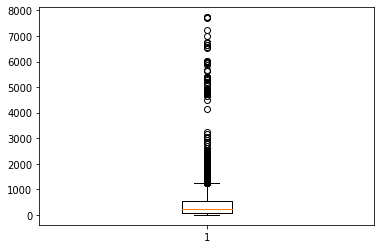

In [57]:
plt.boxplot(performance['random_stock_diff'])
plt.show()

### Pressure Based Recommendation

In [41]:
performance['pressure_stock_diff'].describe()

count    15092.000000
mean       420.389147
std        540.073390
min          0.000000
25%         66.000000
50%        247.000000
75%        589.000000
max       8312.000000
Name: pressure_stock_diff, dtype: float64

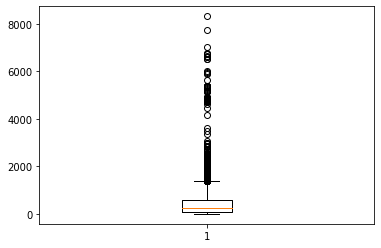

In [54]:
plt.boxplot(performance['pressure_stock_diff'])
plt.show()

### Model Based Recommendation

In [45]:
performance['ml_stock_diff'].describe()

count    15092.000000
mean       385.390936
std        501.186249
min          0.000000
25%         73.000000
50%        232.000000
75%        529.000000
max       8312.000000
Name: ml_stock_diff, dtype: float64

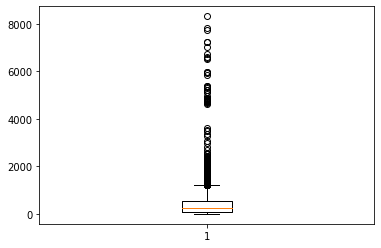

In [56]:
plt.boxplot(performance['ml_stock_diff'])
plt.show()

## Stockfish Elo 1400

In [62]:
performance['stockfish1400_stock_diff'].describe()

count    15092.000000
mean       121.180095
std        290.571515
min          0.000000
25%          0.000000
50%         25.000000
75%        117.000000
max       8312.000000
Name: stockfish1400_stock_diff, dtype: float64

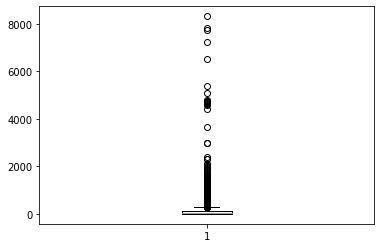

In [63]:
plt.boxplot(performance['stockfish1400_stock_diff'])
plt.show()

## Stockfish Elo 800

In [64]:
performance['stockfish800_stock_diff'].describe()

count    15092.000000
mean       125.281407
std        304.448055
min          0.000000
25%          0.000000
50%         27.000000
75%        125.000000
max       8311.000000
Name: stockfish800_stock_diff, dtype: float64

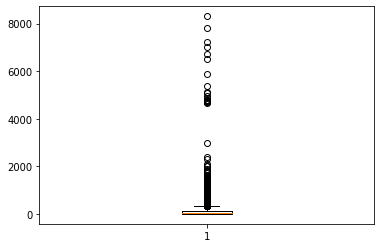

In [66]:
plt.boxplot(performance['stockfish800_stock_diff'])
plt.show()